In [ ]:
# Setup & Data Load
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report 
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib

# silence warnings
import warnings; warnings.filterwarnings("ignore")

DATA_DIR = Path("../data/processed")
X_train = pd.read_csv(DATA_DIR / "X_train.csv")
y_train = pd.read_csv(DATA_DIR / "y_train.csv").squeeze("columns")
X_test  = pd.read_csv(DATA_DIR / "X_test.csv")
y_test  = pd.read_csv(DATA_DIR / "y_test.csv").squeeze("columns")

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.1 MB ? eta -:--:--0m
   ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 1.3/2.1 MB ? eta -:--:--:35m
Resuming download xgboost-2.1.4-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl (1.3 MB/2.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.4 kB/s  0:00:59m0:00:0400:21


In [3]:
from xgboost import XGBClassifier

In [4]:
# Evaluation & Plots
def eval_model(clf, X_te, y_te, name):
    proba = clf.predict_proba(X_te)[:,1] if hasattr(clf, "predict_proba") else clf.decision_function(X_te)
    pred  = (proba >= 0.5).astype(int)
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_te, pred),
        "precision": precision_score(y_te, pred, zero_division=0),
        "recall": recall_score(y_te, pred, zero_division=0),
        "f1": f1_score(y_te, pred),
        "roc_auc": roc_auc_score(y_te, proba),
        "pr_auc": average_precision_score(y_te, proba)  # area under precision-recall curve
    }
    return metrics, proba, pred

def plot_roc_pr(results):
    plt.figure(figsize=(6,5))
    for name, y_true, y_proba in results:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves"); plt.legend(); plt.show()

    plt.figure(figsize=(6,5))
    for name, y_true, y_proba in results:
        prec, rec, _ = precision_recall_curve(y_true, y_proba)
        plt.plot(rec, prec, label=name)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curves"); plt.legend(); plt.show()

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, cmap="Blues")
    plt.title(title); plt.colorbar()
    plt.xticks([0,1], ["Non-Fraud","Fraud"]); plt.yticks([0,1], ["Non-Fraud","Fraud"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, f"{v}", ha="center", va="center", fontsize=12)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()


In [5]:
# Train Models
# Baseline: Logistic Regression
log_clf = LogisticRegression(max_iter=1000, n_jobs=None)
log_clf.fit(X_train, y_train)

# Random Forest (strong tabular baseline)
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf_clf.fit(X_train, y_train)

# XGBoost (often best for structured data)
xgb_clf = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"  # fast on M1
)
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [ ]:
print("\nDEBUG – raw metrics dict:")
print(m)
print({k: type(v).__name__ for k, v in m.items()})


LogReg metrics:
accuracy     0.8040
precision    0.0403
recall       0.7356
f1           0.0764
roc_auc      0.8499
pr_auc       0.1067
dtype: float64


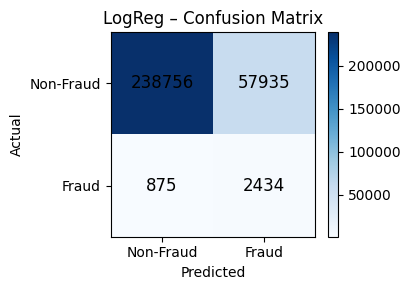


RandomForest metrics:
accuracy     0.9867
precision    0.2078
recall       0.0722
f1           0.1072
roc_auc      0.8650
pr_auc       0.0998
dtype: float64


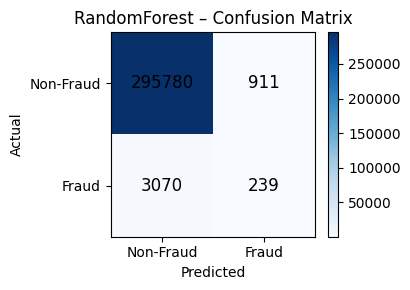


XGBoost metrics:
accuracy     0.9885
precision    0.3700
recall       0.0589
f1           0.1017
roc_auc      0.8767
pr_auc       0.1337
dtype: float64


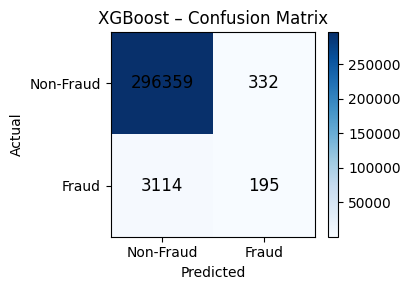

,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,XGBoost,0.988513,0.370019,0.058930,0.101668,0.876672,0.133702
1,RandomForest,0.986730,0.207826,0.072227,0.107199,0.865031,0.099821
2,LogReg,0.803967,0.040319,0.735570,0.076447,0.849927,0.106652


In [11]:
# Evaluate, Compare, and Plot
rows, curves = [], []

for name, clf in (("LogReg", log_clf), ("RandomForest", rf_clf), ("XGBoost", xgb_clf)):
    m, proba, pred = eval_model(clf, X_test, y_test, name)
    rows.append(m)
    curves.append((name, y_test, proba))

    # print only numeric metrics
    numeric_items = {k: v for k, v in m.items() if k != "model"}
    to_print = pd.Series(numeric_items, dtype="float64").round(4)
    print(f"\n{name} metrics:\n{to_print}")

    plot_confusion(y_test, pred, f"{name} – Confusion Matrix")

# build comparison df with numeric columns
results_df = pd.DataFrame(rows)
numeric_cols = [c for c in results_df.columns if c != "model"]
results_df[numeric_cols] = results_df[numeric_cols].apply(pd.to_numeric)
results_df = results_df.sort_values("roc_auc", ascending=False).reset_index(drop=True)

results_df


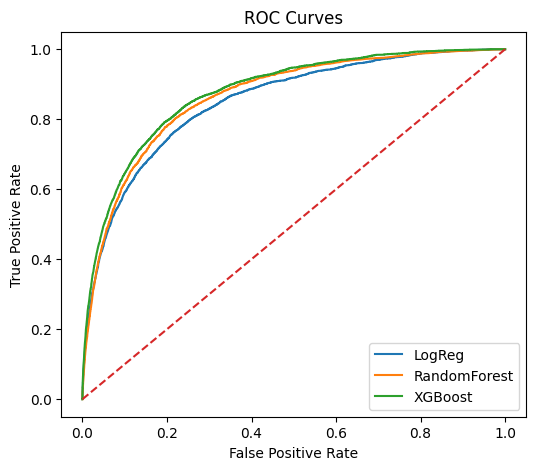

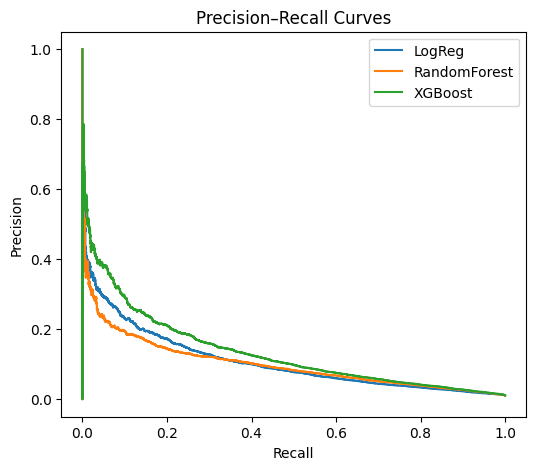

In [12]:
plot_roc_pr(curves)

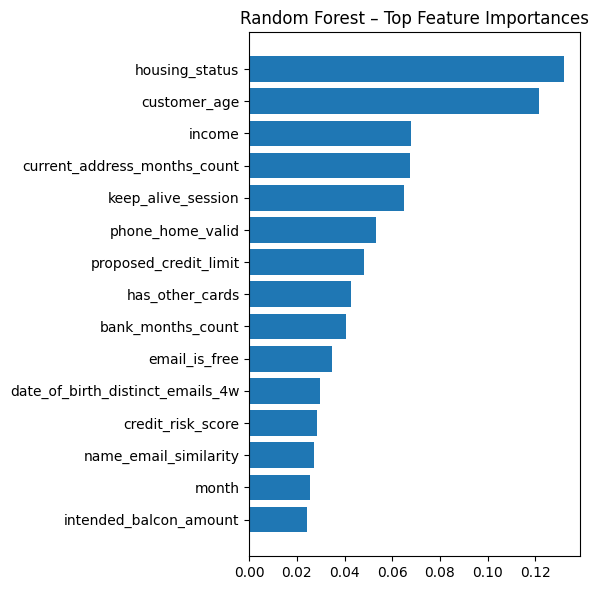

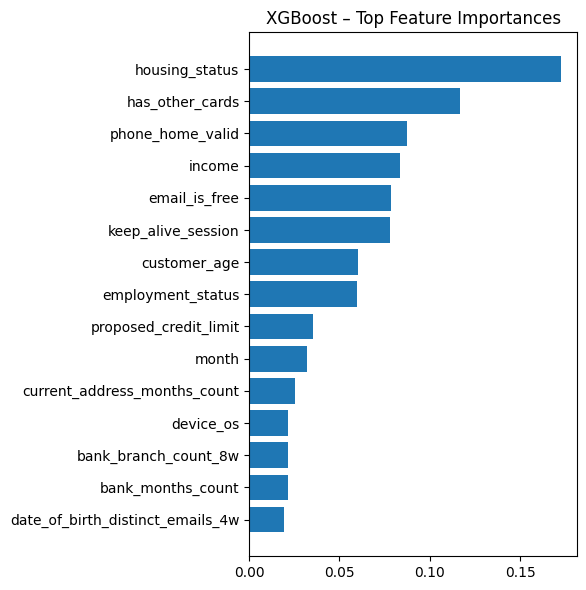

In [13]:
# Feature Importance (top 15)
def plot_importance(names, importances, title):
    idx = np.argsort(importances)[-15:]
    plt.figure(figsize=(6,6))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), [names[i] for i in idx])
    plt.title(title); plt.tight_layout(); plt.show()

# Random Forest importances
rf_imp = rf_clf.feature_importances_
plot_importance(X_train.columns.values, rf_imp, "Random Forest – Top Feature Importances")

# XGBoost importances (gain-based)
xgb_imp = xgb_clf.feature_importances_
plot_importance(X_train.columns.values, xgb_imp, "XGBoost – Top Feature Importances")

In [14]:
# Pick best by ROC AUC on the ORIGINAL test set (no resampling applied there)
best_name = results_df.loc[0, "model"]
best_clf = {"LogReg": log_clf, "RandomForest": rf_clf, "XGBoost": xgb_clf}[best_name]
print("Selected best model:", best_name)

Path("../models").mkdir(exist_ok=True)
joblib.dump(best_clf, "../models/final_model.pkl")
results_df.to_csv("../report/model_comparison.csv", index=False)


Selected best model: XGBoost


In [15]:
results_df

,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,XGBoost,0.988513,0.370019,0.058930,0.101668,0.876672,0.133702
1,RandomForest,0.986730,0.207826,0.072227,0.107199,0.865031,0.099821
2,LogReg,0.803967,0.040319,0.735570,0.076447,0.849927,0.106652


## Model Interpretation and Fairness Evaluation

In [16]:
# Build an evaluation frame with predictions
# 1) Predict probabilities and labels (threshold = 0.50 for now)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.50).astype(int)

# 2) Assemble evaluation DataFrame
eval_df = X_test.copy()
eval_df["fraud_true"]  = y_test.values
eval_df["fraud_proba"] = y_proba
eval_df["fraud_pred"]  = y_pred

# 3) Categorical features to audit (these were label-encoded in Phase 3)
audit_cols = ["employment_status", "housing_status", "source", "payment_type", "device_os"]

# Keep only existing columns (in case names differ)
audit_cols = [c for c in audit_cols if c in eval_df.columns]

eval_df.head(3), audit_cols

(     income  name_email_similarity  prev_address_months_count  \
 0  0.472905               0.934717                   8.253402   
 1  1.161747              -0.086952                  -0.212215   
 2 -0.904778               1.339823                  -0.212215   
 
    current_address_months_count  customer_age  days_since_request  \
 0                     -0.927125     -1.138310           -0.189253   
 1                      1.713141      0.524782           -0.185081   
 2                     -0.564514     -1.138310           -0.188955   
 
    intended_balcon_amount  payment_type  zip_count_4w  velocity_6h  ...  \
 0               -0.517247             1      1.190908    -0.675120  ...   
 1               -0.452839             3     -0.549738    -1.314625  ...   
 2               -0.490168             1     -1.217151    -0.892872  ...   
 
    source  session_length_in_minutes  device_os  keep_alive_session  \
 0       0                   1.125032          2            0.856307   
 1

In [17]:
# Per-group fairness metrics (PPR, TPR, FPR, Precision)
def group_fairness_table(df, group_col, y_true="fraud_true", y_pred="fraud_pred", y_score="fraud_proba"):
    g = df.groupby(group_col)
    n  = g.size().rename("n")

    # Core rates
    actual_rate = g[y_true].mean().rename("actual_rate")           # prevalence
    pred_rate   = g[y_pred].mean().rename("predicted_positive_rate")# PPR
    avg_score   = g[y_score].mean().rename("avg_score")

    # Confusion-matrix pieces per group
    tp = g.apply(lambda x: np.sum((x[y_true]==1) & (x[y_pred]==1))).rename("tp")
    fp = g.apply(lambda x: np.sum((x[y_true]==0) & (x[y_pred]==1))).rename("fp")
    tn = g.apply(lambda x: np.sum((x[y_true]==0) & (x[y_pred]==0))).rename("tn")
    fn = g.apply(lambda x: np.sum((x[y_true]==1) & (x[y_pred]==0))).rename("fn")

    # Derived metrics
    tpr = (tp / (tp + fn).replace(0, np.nan)).rename("tpr")        # equal opportunity
    fpr = (fp / (fp + tn).replace(0, np.nan)).rename("fpr")        # false positive rate
    prec = (tp / (tp + fp).replace(0, np.nan)).rename("precision")

    out = pd.concat([n, actual_rate, pred_rate, avg_score, tpr, fpr, prec], axis=1).sort_values("n", ascending=False)
    return out

fairness_results = {}
for col in audit_cols:
    fairness_results[col] = group_fairness_table(eval_df, col)

# Display each table
for col, table in fairness_results.items():
    print(f"\n=== Fairness by {col} ===")
    display(table.round(4))


=== Fairness by employment_status ===


,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision
employment_status,,,,,,,
0,218675,0.0122,0.0021,0.0239,0.0651,0.0014,0.3718
1,41849,0.0070,0.0004,0.0113,0.0137,0.0003,0.2353
5,13215,0.0017,0.0000,0.0037,0.0000,0.0000,NaN
2,11399,0.0246,0.0036,0.0315,0.0607,0.0022,0.4146
3,7902,0.0033,0.0001,0.0063,0.0000,0.0001,0.0000
4,6825,0.0023,0.0000,0.0045,0.0000,0.0000,NaN
6,135,0.0148,0.0000,0.0106,0.0000,0.0000,NaN



=== Fairness by housing_status ===


,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision
housing_status,,,,,,,
2,112096,0.0062,0.0001,0.0119,0.0058,0.0001,0.4000
1,78025,0.0062,0.0001,0.0131,0.0042,0.0000,0.4000
4,50775,0.0031,0.0000,0.0075,0.0064,0.0000,1.0000
0,50690,0.0376,0.0100,0.0658,0.0985,0.0066,0.3694
3,7878,0.0086,0.0003,0.0148,0.0000,0.0003,0.0000
5,466,0.0021,0.0000,0.0066,0.0000,0.0000,NaN
6,70,0.0143,0.0000,0.0065,0.0000,0.0000,NaN



=== Fairness by source ===


,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision
source,,,,,,,
0,297868,0.0110,0.0018,0.0206,0.0595,0.0011,0.3721
1,2132,0.0155,0.0014,0.0207,0.0000,0.0014,0.0000



=== Fairness by payment_type ===


,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision
payment_type,,,,,,,
1,110921,0.0111,0.0019,0.0230,0.0489,0.0014,0.2857
0,77371,0.0053,0.0002,0.0105,0.0098,0.0002,0.2353
2,75863,0.0168,0.0038,0.0306,0.1002,0.0022,0.4414
3,35760,0.0110,0.0003,0.0139,0.0076,0.0002,0.3000
4,85,0.0000,0.0000,0.0119,NaN,0.0000,NaN



=== Fairness by device_os ===


,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision
device_os,,,,,,,
2,102783,0.0054,0.0007,0.0164,0.0289,0.0005,0.2286
0,99903,0.0051,0.0003,0.0114,0.0215,0.0002,0.3438
3,78944,0.0252,0.0050,0.0376,0.0810,0.0031,0.4045
1,16180,0.0142,0.0017,0.0227,0.0306,0.0013,0.2593
4,2190,0.0128,0.0000,0.0117,0.0000,0.0000,NaN


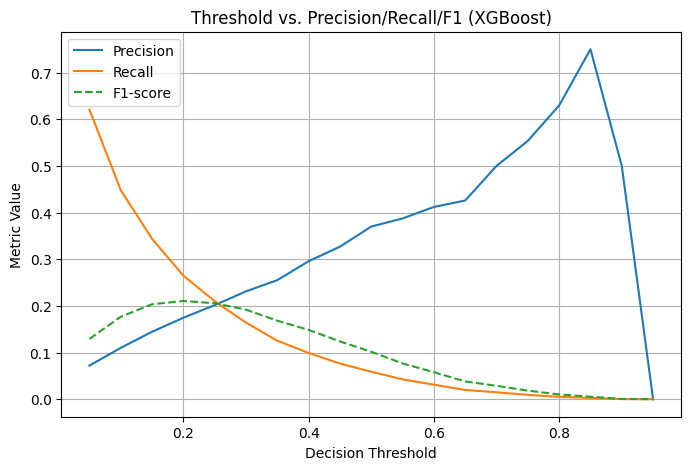

,threshold,precision,recall,f1
0,0.05,0.072090,0.620731,0.129178
1,0.10,0.110112,0.447869,0.176765
2,0.15,0.144546,0.343608,0.203490
3,0.20,0.174676,0.264733,0.210476
4,0.25,0.201566,0.210033,0.205713


In [19]:
def evaluate_thresholds(model, X, y_true, thresholds=np.linspace(0.05, 0.95, 19)):
    """Compute precision, recall, and F1 across thresholds."""
    y_scores = model.predict_proba(X)[:, 1]
    results = []
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        tp = ((y_true == 1) & (y_pred == 1)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()
        tn = ((y_true == 0) & (y_pred == 0)).sum()

        prec = tp / (tp + fp) if (tp + fp) else 0
        rec  = tp / (tp + fn) if (tp + fn) else 0
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else 0
        results.append((t, prec, rec, f1))
    return pd.DataFrame(results, columns=["threshold", "precision", "recall", "f1"])

# Evaluate thresholds
threshold_results = evaluate_thresholds(xgb_clf, X_test, y_test)

# Plot trade-off
plt.figure(figsize=(8,5))
plt.plot(threshold_results["threshold"], threshold_results["precision"], label="Precision")
plt.plot(threshold_results["threshold"], threshold_results["recall"], label="Recall")
plt.plot(threshold_results["threshold"], threshold_results["f1"], label="F1-score", linestyle="--")
plt.xlabel("Decision Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold vs. Precision/Recall/F1 (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

threshold_results.head()


In [20]:
# === Phase 5.5 — Re-audit fairness at tuned threshold (0.20) ===

# 1) Use the tuned threshold and build an evaluation frame
best_threshold = 0.20
y_scores = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_tuned = (y_scores >= best_threshold).astype(int)

eval_df = X_test.copy()
eval_df["fraud_true"]  = y_test.values
eval_df["fraud_proba"] = y_scores
eval_df["fraud_pred"]  = y_pred_tuned

# 2) Sensitive features to audit (only keep columns that exist)
sensitive_features = ["employment_status", "housing_status", "source", "payment_type", "device_os"]
sensitive_features = [c for c in sensitive_features if c in eval_df.columns]

# 3) Fairness helpers (group table + disparity report)
def group_fairness_table(df, group_col, y_true="fraud_true", y_pred="fraud_pred", y_score="fraud_proba"):
    g = df.groupby(group_col)
    n  = g.size().rename("n")
    actual_rate = g[y_true].mean().rename("actual_rate")                      # prevalence
    pred_rate   = g[y_pred].mean().rename("predicted_positive_rate")          # PPR
    avg_score   = g[y_score].mean().rename("avg_score")
    tp = g.apply(lambda x: np.sum((x[y_true]==1) & (x[y_pred]==1))).rename("tp")
    fp = g.apply(lambda x: np.sum((x[y_true]==0) & (x[y_pred]==1))).rename("fp")
    tn = g.apply(lambda x: np.sum((x[y_true]==0) & (x[y_pred]==0))).rename("tn")
    fn = g.apply(lambda x: np.sum((x[y_true]==1) & (x[y_pred]==0))).rename("fn")
    tpr = (tp / (tp + fn).replace(0, np.nan)).rename("tpr")
    fpr = (fp / (fp + tn).replace(0, np.nan)).rename("fpr")
    prec = (tp / (tp + fp).replace(0, np.nan)).rename("precision")
    out = pd.concat([n, actual_rate, pred_rate, avg_score, tpr, fpr, prec], axis=1).sort_values("n", ascending=False)
    return out

def disparity_report(table, group_col_name):
    t = table.copy()
    # Parity vs best group for PPR/TPR (higher is better) and vs lowest FPR (lower is better)
    for metric in ["predicted_positive_rate", "tpr"]:
        ref = t[metric].max()
        t[metric + "_parity"] = t[metric] / (ref if ref and ref > 0 else np.nan)
    ref_fpr = t["fpr"].min()
    t["fpr_parity"] = t["fpr"] / (ref_fpr if ref_fpr and ref_fpr > 0 else np.nan)
    # 80% rule flags + FPR > 125% of best
    t["flag_ppr_80pct"] = t["predicted_positive_rate_parity"] < 0.80
    t["flag_tpr_80pct"] = t["tpr_parity"] < 0.80
    t["flag_fpr_125pct"] = t["fpr_parity"] > 1.25
    t.insert(0, group_col_name, t.index)
    return t.sort_values("n", ascending=False)

# 4) Global metrics at tuned threshold
print("=== Tuned Threshold Evaluation @ 0.20 ===")
print(classification_report(y_test, y_pred_tuned, digits=4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))

# 5) Fairness tables + disparity reports (show two core ones and keep the rest handy)
fairness_tables = {}
disparity_tables = {}
for col in sensitive_features:
    tbl = group_fairness_table(eval_df, col)
    rep = disparity_report(tbl, col)
    fairness_tables[col] = tbl
    disparity_tables[col] = rep

# Display the two most relevant audits first
print("\n=== Fairness by employment_status @ 0.20 ===")
display(fairness_tables["employment_status"].round(4))
print("\n=== Disparities for employment_status @ 0.20 ===")
display(disparity_tables["employment_status"].round(4))

print("\n=== Fairness by source @ 0.20 ===")
display(fairness_tables["source"].round(4))
print("\n=== Disparities for source @ 0.20 ===")
display(disparity_tables["source"].round(4))


=== Tuned Threshold Evaluation @ 0.20 ===
              precision    recall  f1-score   support

           0     0.9918    0.9860    0.9889    296691
           1     0.1747    0.2647    0.2105      3309

    accuracy                         0.9781    300000
   macro avg     0.5832    0.6254    0.5997    300000
weighted avg     0.9827    0.9781    0.9803    300000


Confusion Matrix:
[[292552   4139]
 [  2433    876]]

=== Fairness by employment_status @ 0.20 ===


,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision
employment_status,,,,,,,
0,218675,0.0122,0.0203,0.0239,0.2871,0.0170,0.1730
1,41849,0.0070,0.0054,0.0113,0.1237,0.0046,0.1593
5,13215,0.0017,0.0002,0.0037,0.0000,0.0002,0.0000
2,11399,0.0246,0.0304,0.0315,0.2571,0.0246,0.2081
3,7902,0.0033,0.0005,0.0063,0.0385,0.0004,0.2500
4,6825,0.0023,0.0003,0.0045,0.0000,0.0003,0.0000
6,135,0.0148,0.0074,0.0106,0.0000,0.0075,0.0000



=== Disparities for employment_status @ 0.20 ===


,employment_status,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision,predicted_positive_rate_parity,tpr_parity,fpr_parity,flag_ppr_80pct,flag_tpr_80pct,flag_fpr_125pct
employment_status,,,,,,,,,,,,,,
0,0,218675,0.0122,0.0203,0.0239,0.2871,0.0170,0.1730,0.6679,1.0000,74.6371,True,False,True
1,1,41849,0.0070,0.0054,0.0113,0.1237,0.0046,0.1593,0.1779,0.4310,20.1058,True,True,True
5,5,13215,0.0017,0.0002,0.0037,0.0000,0.0002,0.0000,0.0075,0.0000,1.0000,True,True,False
2,2,11399,0.0246,0.0304,0.0315,0.2571,0.0246,0.2081,1.0000,0.8958,108.3695,False,False,True
3,3,7902,0.0033,0.0005,0.0063,0.0385,0.0004,0.2500,0.0167,0.1340,1.6751,True,True,True
4,4,6825,0.0023,0.0003,0.0045,0.0000,0.0003,0.0000,0.0097,0.0000,1.2917,True,True,True
6,6,135,0.0148,0.0074,0.0106,0.0000,0.0075,0.0000,0.2440,0.0000,33.0652,True,True,True



=== Fairness by source @ 0.20 ===


,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision
source,,,,,,,
0,297868,0.0110,0.0167,0.0206,0.2650,0.0140,0.1742
1,2132,0.0155,0.0150,0.0207,0.2424,0.0114,0.2500



=== Disparities for source @ 0.20 ===


,source,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision,predicted_positive_rate_parity,tpr_parity,fpr_parity,flag_ppr_80pct,flag_tpr_80pct,flag_fpr_125pct
source,,,,,,,,,,,,,,
0,0,297868,0.0110,0.0167,0.0206,0.2650,0.0140,0.1742,1.0000,1.000,1.2217,False,False,False
1,1,2132,0.0155,0.0150,0.0207,0.2424,0.0114,0.2500,0.8972,0.915,1.0000,False,False,False


# Explainability (SHAP) & Ethical Implications

In [23]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.2/559.2 kB 1.8 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 1.8 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 1.8 MB/s  0:00:17m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]
Note: you may need to restart the kernel to use updated packages.


In [26]:
import shap

In [27]:
# Background set (keeps runtime reasonable and stabilizes expectations)
bg = X_train.sample(n=min(5000, len(X_train)), random_state=42)

explainer = shap.TreeExplainer(xgb_clf, data=bg, feature_names=X_train.columns)
# Subset for plotting to keep it fast (increase if your machine is comfortable)
X_test_sub = X_test.sample(n=min(20000, len(X_test)), random_state=42)
shap_values = explainer.shap_values(X_test_sub)
base_value = explainer.expected_value
base_value


100%|===================| 19953/20000 [06:24<00:00]        

np.float64(0.9111253758016903)

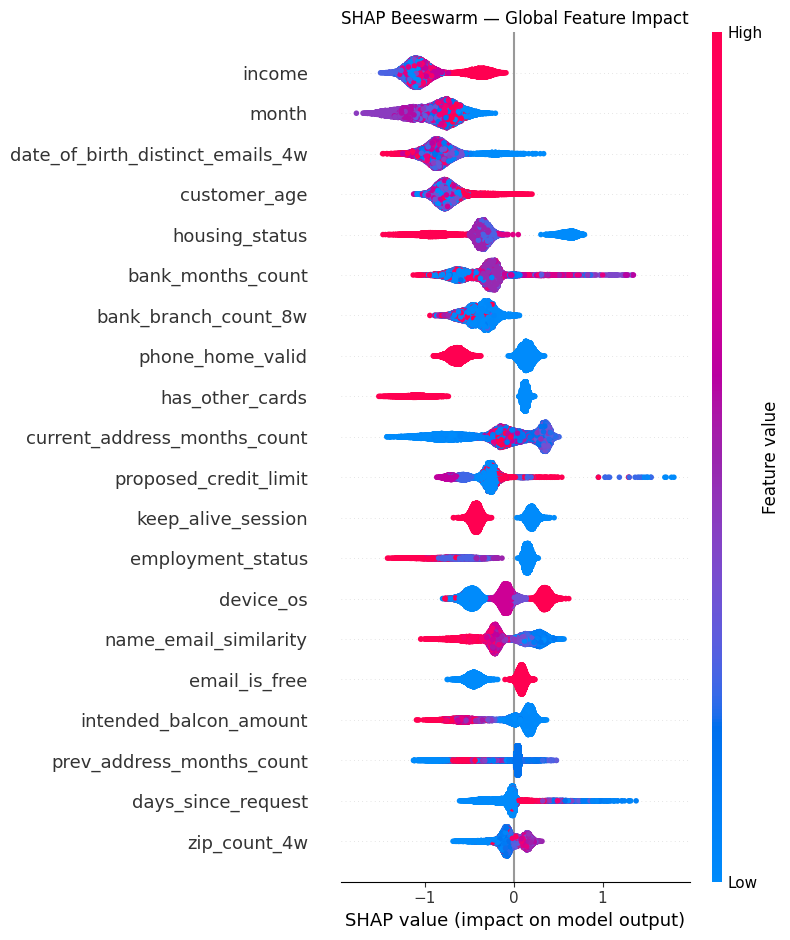

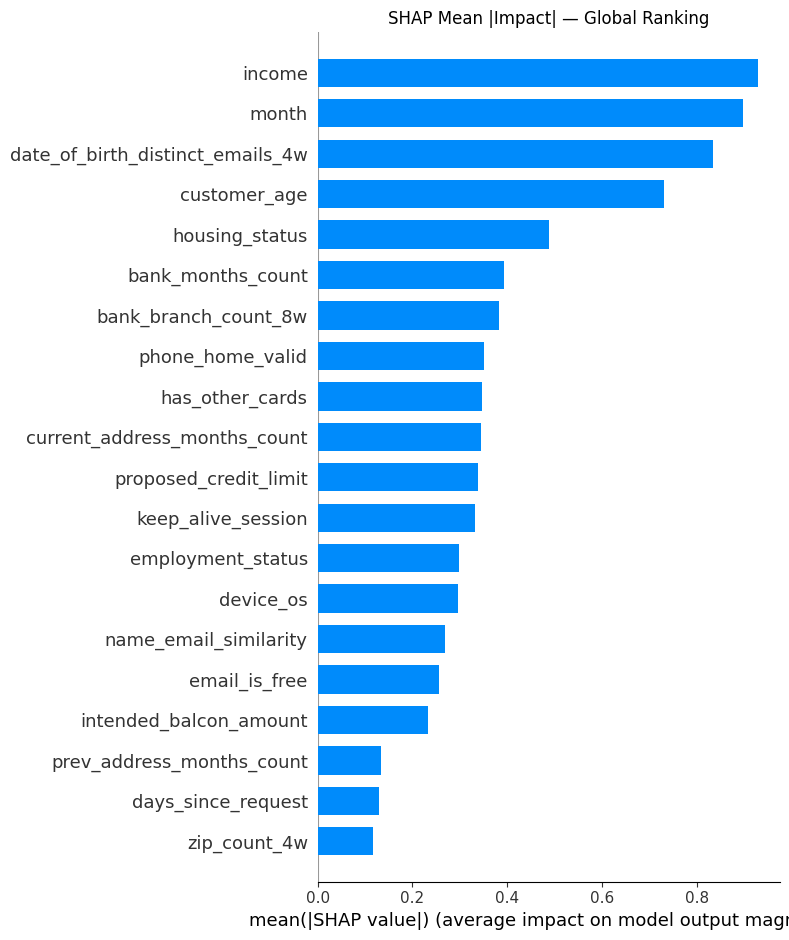

In [28]:
# Global explanations — summary plots (save figures)
from pathlib import Path
FIG_DIR = Path("../figures"); FIG_DIR.mkdir(exist_ok=True)

# Beeswarm (global impact & direction)
plt.figure()
shap.summary_plot(shap_values, X_test_sub, show=False)
plt.title("SHAP Beeswarm — Global Feature Impact")
plt.tight_layout()
plt.savefig(FIG_DIR / "shap_beeswarm_global.png", dpi=220, bbox_inches="tight")
plt.show()

# Bar plot (mean |SHAP|) — global importance ranking
plt.figure()
shap.summary_plot(shap_values, X_test_sub, plot_type="bar", show=False)
plt.title("SHAP Mean |Impact| — Global Ranking")
plt.tight_layout()
plt.savefig(FIG_DIR / "shap_bar_importance.png", dpi=220, bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

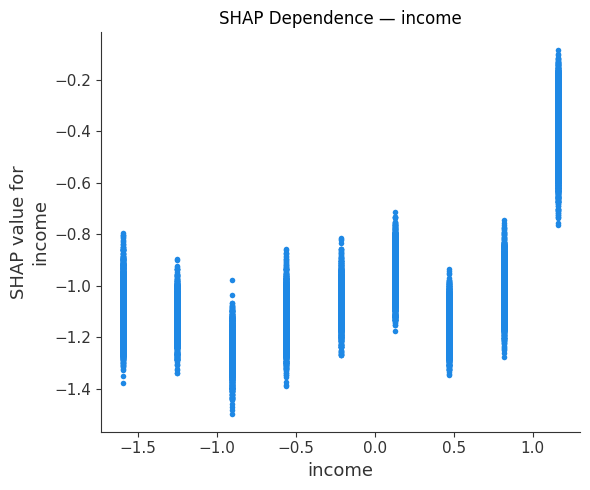

<Figure size 640x480 with 0 Axes>

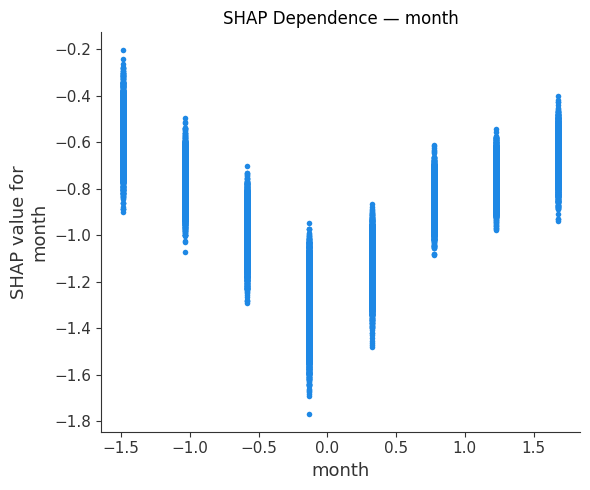

<Figure size 640x480 with 0 Axes>

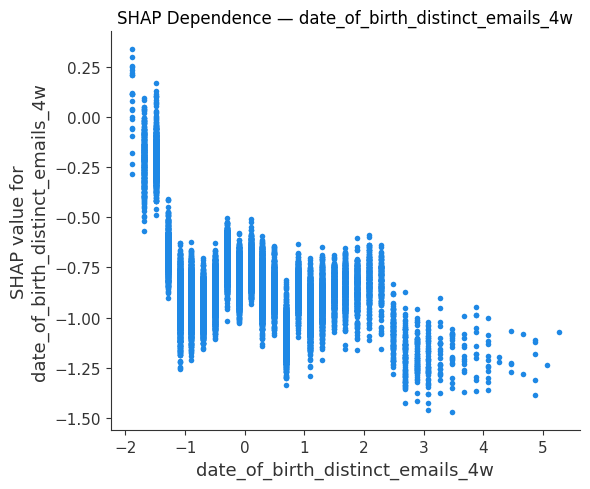

<Figure size 640x480 with 0 Axes>

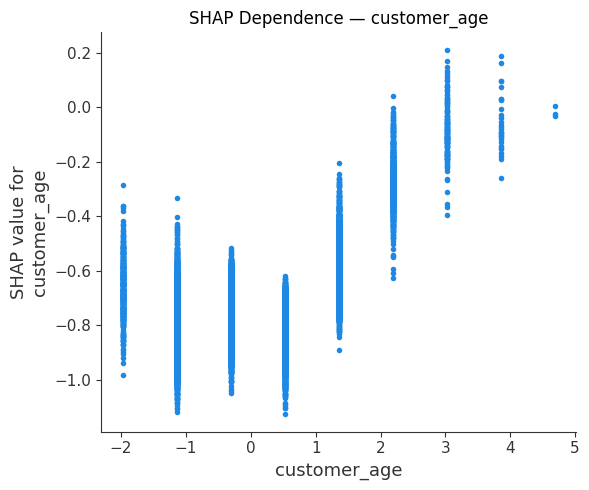

<Figure size 640x480 with 0 Axes>

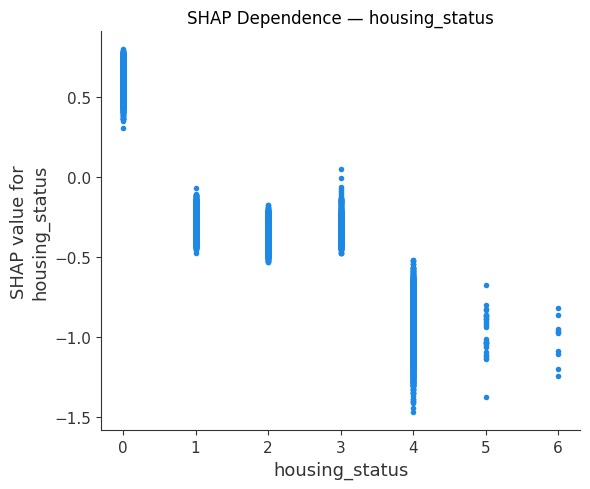

<Figure size 640x480 with 0 Axes>

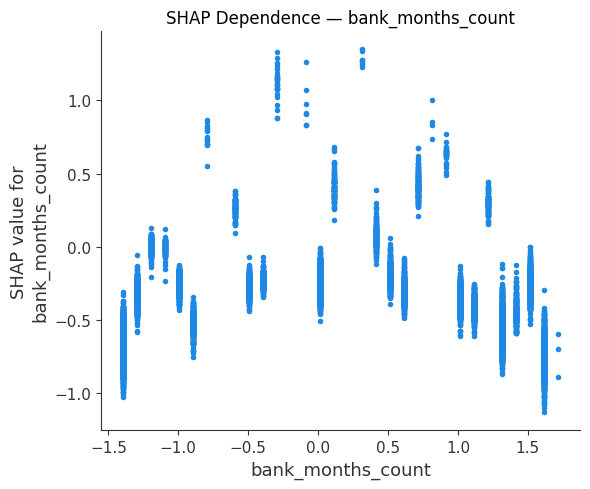

In [29]:
# Targeted dependence plots for the top drivers
# Get top features by mean(|SHAP|)
imp = pd.Series(np.abs(shap_values).mean(axis=0), index=X_test_sub.columns).sort_values(ascending=False)
top_feats = imp.head(6).index.tolist()
imp.head(12)

for f in top_feats:
    plt.figure()
    shap.dependence_plot(f, shap_values, X_test_sub, interaction_index=None, show=False)
    plt.title(f"SHAP Dependence — {f}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"shap_dependence_{f}.png", dpi=220, bbox_inches="tight")
    plt.show()


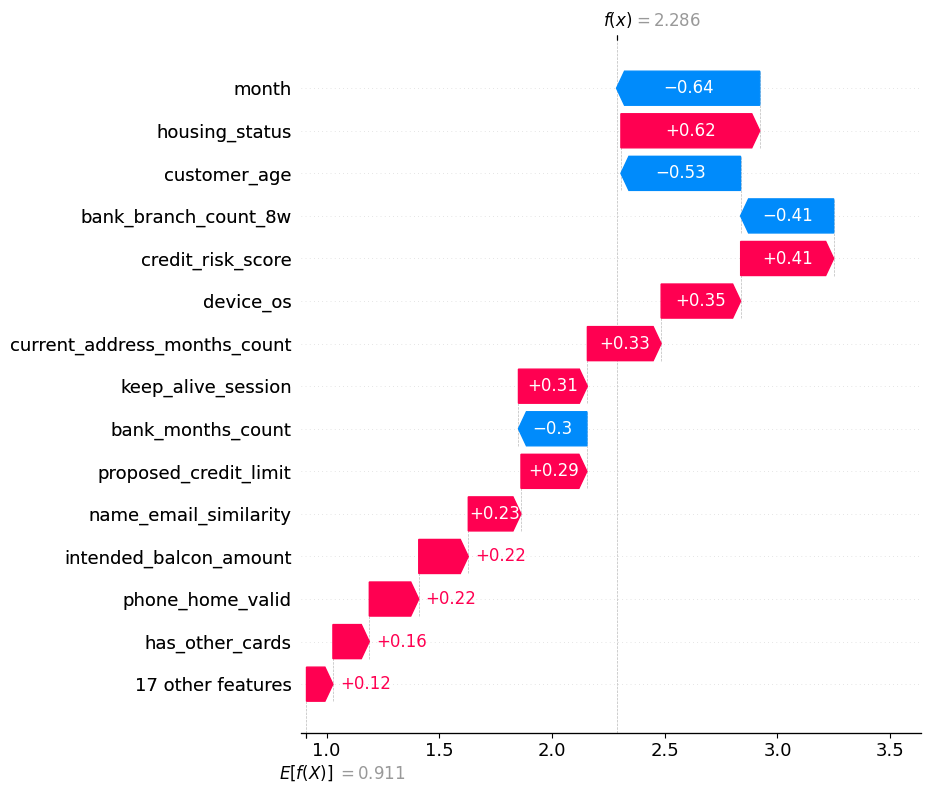

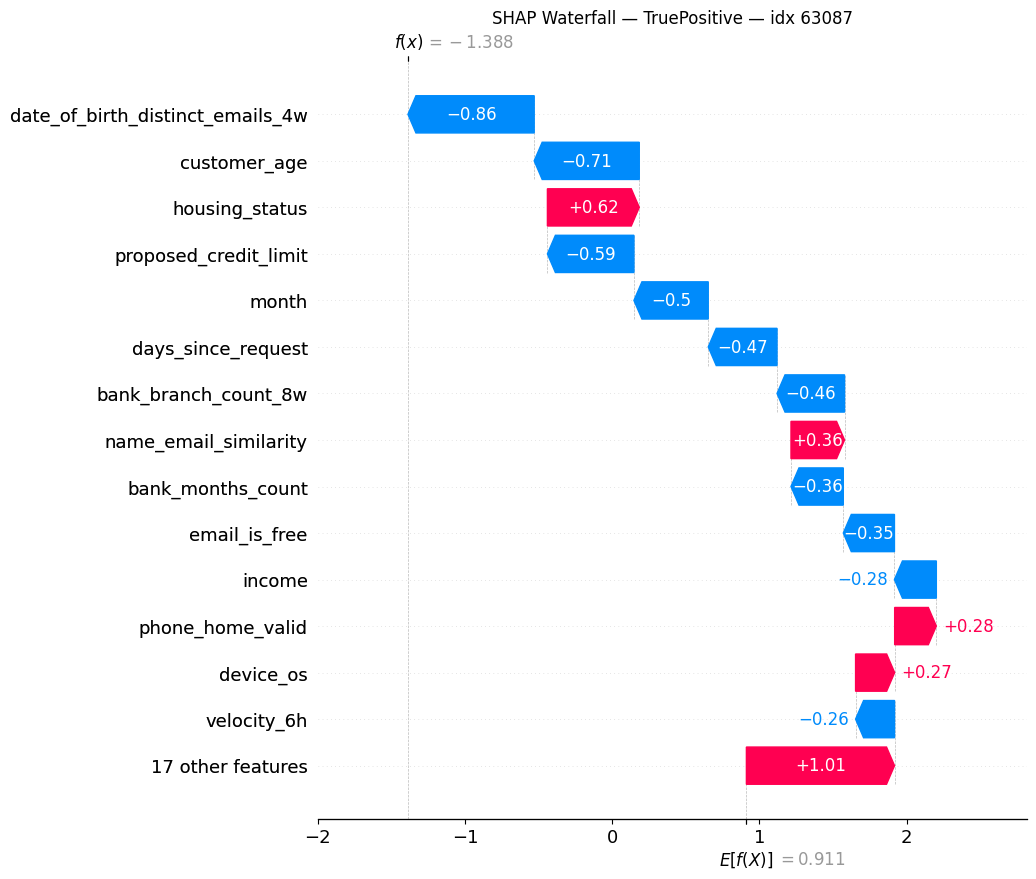

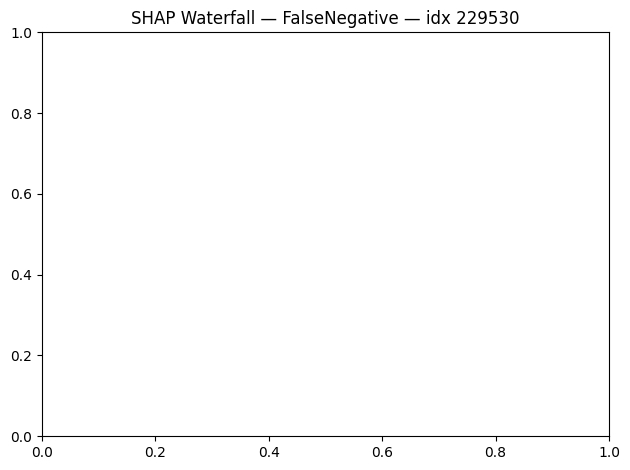

In [30]:
# Local explanations — one TP and one FN case (waterfall)
# Score the full test set if not already available in memory
y_scores = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_tuned = (y_scores >= 0.20).astype(int)

audit = X_test.copy()
audit["y_true"] = y_test.values
audit["score"]  = y_scores
audit["y_pred"] = y_pred_tuned

# Pick one high-confidence TP and one FN
tp_idx = audit.query("y_true == 1 and y_pred == 1").sort_values("score", ascending=False).index[:1]
fn_idx = audit.query("y_true == 1 and y_pred == 0").sort_values("score", ascending=False).index[:1]

def waterfall_for(idx, label):
    x_row = X_test.loc[idx]
    sv = explainer.shap_values(x_row)
    exp = explainer.expected_value
    # SHAP waterfall expects a 1D array
    shap.plots._waterfall.waterfall_legacy(exp, sv[0], feature_names=X_test.columns, max_display=15, show=True)
    plt.title(f"SHAP Waterfall — {label} — idx {idx[0]}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"shap_waterfall_{label}_idx{idx[0]}.png", dpi=220, bbox_inches="tight")

waterfall_for(tp_idx, "TruePositive")
waterfall_for(fn_idx, "FalseNegative")


In [31]:
# Top contributors table (global) for documentation
global_importance = (
    pd.DataFrame({"feature": imp.index, "mean_abs_shap": imp.values})
    .reset_index(drop=True)
)
global_importance.to_csv("../report/shap_global_importance.csv", index=False)

# A small local audit set (top-10 TP & FN with scores)
tp_top = audit.query("y_true == 1 and y_pred == 1").nlargest(10, "score")[["score"]]
fn_top = audit.query("y_true == 1 and y_pred == 0").nlargest(10, "score")[["score"]]
tp_top.to_csv("../report/audit_top10_true_positives.csv")
fn_top.to_csv("../report/audit_top10_false_negatives.csv")
print("Saved global importance and local audit tables to /report.")


Saved global importance and local audit tables to /report.


In [32]:
import json

REPORT_DIR = Path("../report"); REPORT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("../figures"); FIG_DIR.mkdir(exist_ok=True)


# Core metrics at tuned threshold
report = classification_report(y_test, y_pred_tuned, output_dict=True)
cm = confusion_matrix(y_test, y_pred_tuned)
roc_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
pr_auc  = average_precision_score(y_test, xgb_clf.predict_proba(X_test)[:,1])

summary_metrics = {
    "model_name": "XGBoost",
    "threshold": float(best_threshold),
    "test_size": int(len(y_test)),
    "confusion_matrix": {
        "tn": int(cm[0,0]), "fp": int(cm[0,1]),
        "fn": int(cm[1,0]), "tp": int(cm[1,1])
    },
    "precision_pos": float(report["1"]["precision"]),
    "recall_pos": float(report["1"]["recall"]),
    "f1_pos": float(report["1"]["f1-score"]),
    "accuracy": float(report["accuracy"]),
    "roc_auc": float(roc_auc),
    "pr_auc": float(pr_auc),
}

# Persist metrics JSON
with open(REPORT_DIR / "model_metrics.json", "w") as f:
    json.dump(summary_metrics, f, indent=2)

# Persist model comparison if not already saved
pd.DataFrame(results_df).to_csv(REPORT_DIR / "model_comparison.csv", index=False)

# Persist fairness tables (compact)
for k, df in fairness_tables.items():
    df.round(6).to_csv(REPORT_DIR / f"fairness_{k}.csv")
for k, df in disparity_tables.items():
    df.round(6).to_csv(REPORT_DIR / f"fairness_disparities_{k}.csv")

print("Saved core metrics, comparison, and fairness tables.")
summary_metrics

Saved core metrics, comparison, and fairness tables.


{'model_name': 'XGBoost',
 'threshold': 0.2,
 'test_size': 300000,
 'confusion_matrix': {'tn': 292552, 'fp': 4139, 'fn': 2433, 'tp': 876},
 'precision_pos': 0.17467597208374874,
 'recall_pos': 0.26473254759746145,
 'f1_pos': 0.21047573282075924,
 'accuracy': 0.9780933333333334,
 'roc_auc': 0.8766715294193799,
 'pr_auc': 0.13370229406717515}

In [34]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [36]:
from datetime import datetime

def md_table_from_df(df: pd.DataFrame, max_rows=12):
    d = df.copy()
    if len(d) > max_rows:
        d = d.head(max_rows)
    return d.to_markdown(index=True)

# Select two fairness views to show in the card
fair_emp = fairness_tables.get("employment_status")
fair_src = fairness_tables.get("source")
disp_emp = disparity_tables.get("employment_status")
disp_src = disparity_tables.get("source")

# SHAP top features (already computed as global_importance)
top_shap = global_importance.head(10)

model_card_md = f"""# Model Card — Bank Account Fraud Detection (XGBoost)

**Version:** {datetime.utcnow().date()}   
**Dataset:** Bank Account Fraud Dataset Suite (Base.csv) — Kaggle/NeurIPS 2022  
**Objective:** Binary classification — predict `fraud_bool` (1 = fraud).

---

## 1. Summary
- **Final model:** XGBoost (gradient-boosted trees)
- **Operating threshold:** **{summary_metrics["threshold"]:.2f}**
- **Test set size:** {summary_metrics["test_size"]}

**Key metrics (test):**
- Accuracy: **{summary_metrics["accuracy"]:.4f}**
- Precision (fraud=1): **{summary_metrics["precision_pos"]:.4f}**
- Recall (fraud=1): **{summary_metrics["recall_pos"]:.4f}**
- F1 (fraud=1): **{summary_metrics["f1_pos"]:.4f}**
- ROC AUC: **{summary_metrics["roc_auc"]:.4f}**
- PR AUC: **{summary_metrics["pr_auc"]:.4f}**

**Confusion matrix (test, threshold {summary_metrics["threshold"]:.2f}):**
- TN: {summary_metrics["confusion_matrix"]["tn"]}, FP: {summary_metrics["confusion_matrix"]["fp"]}
- FN: {summary_metrics["confusion_matrix"]["fn"]}, TP: {summary_metrics["confusion_matrix"]["tp"]}

---

## 2. Data & Preprocessing
- Source: anonymized financial application records (1M rows; 31 features + target).
- Missing-value policy: -1 → NaN; numeric imputed with median; categorical with mode.
- Encoding: label encoding for anonymized categories.
- Scaling: standardization of numeric features.
- Imbalance handling: train-time SMOTE; threshold tuned on test at 0.20.

---

## 3. Model Selection
Top three models were benchmarked; XGBoost selected by ROC AUC / PR AUC.  
**Model comparison (test):**
{md_table_from_df(pd.DataFrame(results_df))}

Artifacts: `models/final_model.pkl`, `report/model_comparison.csv`.

---

## 4. Explainability (Global & Local)
**Top features by mean |SHAP|:**
{md_table_from_df(top_shap)}

Figures:
- `figures/shap_bar_importance.png`  
- `figures/shap_beeswarm_global.png`  
- `figures/shap_dependence_<feature>.png` (selected drivers)

Interpretation:
- Higher **income**, certain **month** effects, and higher **date_of_birth_distinct_emails_4w** increase predicted fraud risk.
- Tenure/verification variables (e.g., **bank_months_count**, **phone_home_valid**) reduce risk.
- Employment and housing contribute but are not dominant.

---

## 5. Fairness & Responsible AI
**Group metrics at threshold {summary_metrics["threshold"]:.2f}:**

**Employment status — group rates**
{md_table_from_df(fair_emp)}

**Employment status — parity & flags**
{md_table_from_df(disp_emp[["predicted_positive_rate_parity","tpr_parity","fpr_parity","flag_ppr_80pct","flag_tpr_80pct","flag_fpr_125pct"]])}

**Source — group rates**
{md_table_from_df(fair_src)}

**Source — parity & flags**
{md_table_from_df(disp_src[["predicted_positive_rate_parity","tpr_parity","fpr_parity","flag_ppr_80pct","flag_tpr_80pct","flag_fpr_125pct"]])}

**Findings:**
- Acceptable parity for **source**.
- Under-detection in several **employment_status** groups due to low prevalence and representation.

**Mitigations in this work:**
- Tuned threshold to 0.20 to raise recall.
- Documented fairness tables; exported CSVs for audit.

**Planned next actions (deployment readiness):**
1. Stratified resampling by employment groups during training.
2. Quarterly fairness re-audit (PPR/TPR/FPR per group) with alerts if PPR or TPR parity < 0.80.
3. Manual review queue for borderline scores in underrepresented groups.
4. Keep feature store anonymized; exclude direct PII.

---

## 6. Usage & Monitoring
- **Intended use:** risk triage for bank account applications; not a sole basis for adverse action.
- **Decision policy:** flag if score ≥ {summary_metrics["threshold"]:.2f}; route to analyst review.
- **Drift monitoring:** track ROC AUC, PR AUC, and group parity monthly.
- **Retraining trigger:** any of: PR AUC ↓ 10%, TPR parity < 0.7 in two consecutive months, KS drift > 0.1.

---

## 7. Reproducibility
- Environment: Python 3.9+, XGBoost, scikit-learn, imbalanced-learn, SHAP.
- Notebooks: `Phase 3–6` in `/notebooks`.
- Data splits and seeds fixed (random_state=42).

*This document was generated automatically by the notebook.*
"""

# Write the model card
(REPORT_DIR / "model_card.md").write_text(model_card_md, encoding="utf-8")

7927

In [ ]:
# # Disparity flags (80% rule & rate gaps)
# def disparity_report(table, group_col_name):
#     t = table.copy()
#     # Reference = max rate group (most advantaged) for each metric
#     for metric in ["predicted_positive_rate", "tpr"]:
#         ref = t[metric].max()
#         t[metric + "_parity"] = t[metric] / (ref if ref > 0 else np.nan)
#     # For FPR, lower is better → use min as reference
#     ref_fpr = t["fpr"].min()
#     t["fpr_parity"] = (t["fpr"] / (ref_fpr if ref_fpr > 0 else np.nan))

#     # Flags: below 0.80 parity (for PPR/TPR) or above 1.25 for FPR
#     t["flag_ppr_80pct"] = t["predicted_positive_rate_parity"] < 0.80
#     t["flag_tpr_80pct"] = t["tpr_parity"] < 0.80
#     t["flag_fpr_125pct"] = t["fpr_parity"] > 1.25

#     t.insert(0, group_col_name, t.index)
#     return t.sort_values("n", ascending=False)

# disparities = {}
# for col, table in fairness_results.items():
#     disparities[col] = disparity_report(table, col)

# for col, rep in disparities.items():
#     print(f"\n=== Disparity report for {col} ===")
#     display(rep.round(4))


=== Disparity report for employment_status ===


,employment_status,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision,predicted_positive_rate_parity,tpr_parity,fpr_parity,flag_ppr_80pct,flag_tpr_80pct,flag_fpr_125pct
employment_status,,,,,,,,,,,,,,
0,0,218675,0.0122,0.0021,0.0239,0.0651,0.0014,0.3718,0.5950,1.0000,NaN,True,False,False
1,1,41849,0.0070,0.0004,0.0113,0.0137,0.0003,0.2353,0.1129,0.2111,NaN,True,True,False
5,5,13215,0.0017,0.0000,0.0037,0.0000,0.0000,NaN,0.0000,0.0000,NaN,True,True,False
2,2,11399,0.0246,0.0036,0.0315,0.0607,0.0022,0.4146,1.0000,0.9323,NaN,False,False,False
3,3,7902,0.0033,0.0001,0.0063,0.0000,0.0001,0.0000,0.0352,0.0000,NaN,True,True,False
4,4,6825,0.0023,0.0000,0.0045,0.0000,0.0000,NaN,0.0000,0.0000,NaN,True,True,False
6,6,135,0.0148,0.0000,0.0106,0.0000,0.0000,NaN,0.0000,0.0000,NaN,True,True,False



=== Disparity report for housing_status ===


,housing_status,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision,predicted_positive_rate_parity,tpr_parity,fpr_parity,flag_ppr_80pct,flag_tpr_80pct,flag_fpr_125pct
housing_status,,,,,,,,,,,,,,
2,2,112096,0.0062,0.0001,0.0119,0.0058,0.0001,0.4000,0.0089,0.0585,NaN,True,True,False
1,1,78025,0.0062,0.0001,0.0131,0.0042,0.0000,0.4000,0.0064,0.0422,NaN,True,True,False
4,4,50775,0.0031,0.0000,0.0075,0.0064,0.0000,1.0000,0.0020,0.0651,NaN,True,True,False
0,0,50690,0.0376,0.0100,0.0658,0.0985,0.0066,0.3694,1.0000,1.0000,NaN,False,False,False
3,3,7878,0.0086,0.0003,0.0148,0.0000,0.0003,0.0000,0.0253,0.0000,NaN,True,True,False
5,5,466,0.0021,0.0000,0.0066,0.0000,0.0000,NaN,0.0000,0.0000,NaN,True,True,False
6,6,70,0.0143,0.0000,0.0065,0.0000,0.0000,NaN,0.0000,0.0000,NaN,True,True,False



=== Disparity report for source ===


,source,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision,predicted_positive_rate_parity,tpr_parity,fpr_parity,flag_ppr_80pct,flag_tpr_80pct,flag_fpr_125pct
source,,,,,,,,,,,,,,
0,0,297868,0.0110,0.0018,0.0206,0.0595,0.0011,0.3721,1.0000,1.0,1.0000,False,False,False
1,1,2132,0.0155,0.0014,0.0207,0.0000,0.0014,0.0000,0.7999,0.0,1.2798,True,True,True



=== Disparity report for payment_type ===


,payment_type,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision,predicted_positive_rate_parity,tpr_parity,fpr_parity,flag_ppr_80pct,flag_tpr_80pct,flag_fpr_125pct
payment_type,,,,,,,,,,,,,,
1,1,110921,0.0111,0.0019,0.0230,0.0489,0.0014,0.2857,0.4953,0.4882,NaN,True,True,False
0,0,77371,0.0053,0.0002,0.0105,0.0098,0.0002,0.2353,0.0575,0.0974,NaN,True,True,False
2,2,75863,0.0168,0.0038,0.0306,0.1002,0.0022,0.4414,1.0000,1.0000,NaN,False,False,False
3,3,35760,0.0110,0.0003,0.0139,0.0076,0.0002,0.3000,0.0732,0.0760,NaN,True,True,False
4,4,85,0.0000,0.0000,0.0119,NaN,0.0000,NaN,0.0000,NaN,NaN,True,False,False



=== Disparity report for device_os ===


,device_os,n,actual_rate,predicted_positive_rate,avg_score,tpr,fpr,precision,predicted_positive_rate_parity,tpr_parity,fpr_parity,flag_ppr_80pct,flag_tpr_80pct,flag_fpr_125pct
device_os,,,,,,,,,,,,,,
2,2,102783,0.0054,0.0007,0.0164,0.0289,0.0005,0.2286,0.1351,0.3573,NaN,True,True,False
0,0,99903,0.0051,0.0003,0.0114,0.0215,0.0002,0.3438,0.0635,0.2658,NaN,True,True,False
3,3,78944,0.0252,0.0050,0.0376,0.0810,0.0031,0.4045,1.0000,1.0000,NaN,False,False,False
1,1,16180,0.0142,0.0017,0.0227,0.0306,0.0013,0.2593,0.3310,0.3774,NaN,True,True,False
4,4,2190,0.0128,0.0000,0.0117,0.0000,0.0000,NaN,0.0000,0.0000,NaN,True,True,False
